In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
credit_df = pd.read_csv('../data/raw/creditcard.csv')


In [3]:
# show data head
print(fraud_df.head())
print(ip_df.head())
print(credit_df.head())

   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


In [4]:
# Check for nulls
print(fraud_df.isnull().sum())

# Drop or impute missing values
fraud_df.dropna(inplace=True)  # OR use imputation for relevant columns

# Remove duplicates
fraud_df.drop_duplicates(inplace=True)

# Fix datetime types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
print(fraud_df.head())


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  S

Text(0.5, 1.0, 'Fraudulent vs Non-Fraudulent Transactions')

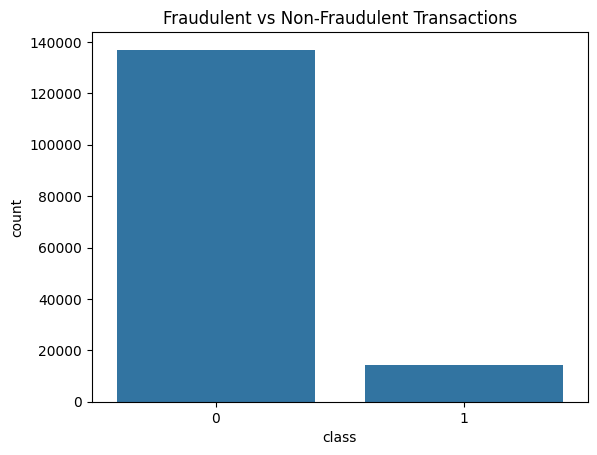

In [5]:
# Class distribution
sns.countplot(data=fraud_df, x='class')
plt.title("Fraudulent vs Non-Fraudulent Transactions")



<Axes: xlabel='age', ylabel='Count'>

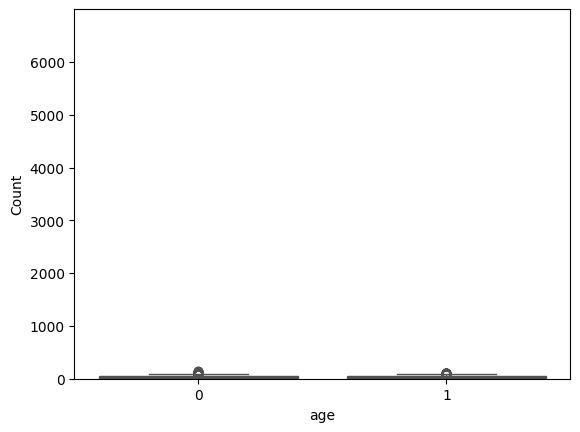

In [6]:
# Distribution plots
sns.histplot(fraud_df['age'], kde=True)
sns.boxplot(x='class', y='purchase_value', data=fraud_df)

<Axes: >

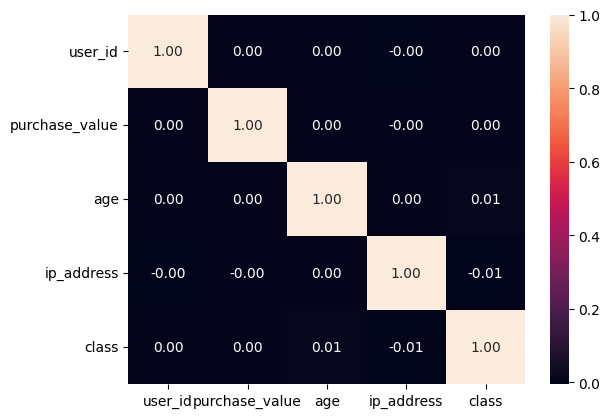

In [7]:
# Correlation matrix
corr = fraud_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f")

In [8]:
# Interval merge
def get_country(ip_int):
    row = ip_df[(ip_df['lower_bound_ip_address'] <= ip_int) & (ip_df['upper_bound_ip_address'] >= ip_int)]
    return row['country'].values[0] if not row.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_address'].apply(get_country)


In [9]:
# Time-based features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600

# Transaction frequency
fraud_df['user_tx_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')


In [10]:
# Encode categorical features
fraud_df = pd.get_dummies(fraud_df, columns=['source', 'browser', 'sex', 'country'], drop_first=True)

# Feature scaling
scaler = StandardScaler()
fraud_df['purchase_value_scaled'] = scaler.fit_transform(fraud_df[['purchase_value']])

# Handle class imbalance
X = fraud_df.drop(['class', 'user_id', 'device_id', 'signup_time', 'purchase_time'], axis=1)
y = fraud_df['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score

lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

for name, model in models.items():
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # AUC-PR
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    print("AUC-PR:", pr_auc)


=== Logistic Regression ===
F1 Score: 0.3099737310397424
Confusion Matrix:
 [[20251  7142]
 [ 1001  1829]]
AUC-PR: 0.2762693132445916

=== Random Forest ===
F1 Score: 0.6290555899979334
Confusion Matrix:
 [[26906   487]
 [ 1308  1522]]
AUC-PR: 0.6233496089327232


c:\Users\hp\Documents\Kifya-AI\fraud-detection-week8&9\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
F1 Score: 0.5998433829287392
Confusion Matrix:
 [[26647   746]
 [ 1298  1532]]
AUC-PR: 0.599884528127315


: 

In [ ]:
import shap
import numpy as np

# Sample 100 rows from test set that are already processed (encoded + scaled)
X_sample = X_test.select_dtypes(include=[np.number]).sample(n=100, random_state=42)


# Unified SHAP explainer (should now work!)
explainer = shap.Explainer(rf, X_sample)
shap_values = explainer(X_sample)

# Global summary plot
shap.summary_plot(shap_values, X_sample)


c:\Users\hp\Documents\Kifya-AI\fraud-detection-week8&9\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
